In [3]:
import pandas as pd
from binance.spot import Spot
from tqdm.auto import tqdm
import numpy as np  
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime, timedelta

In [4]:
client = Spot()

In [41]:
def processing_data(data):
    data.columns = ['kline_open_time', 'open_price','high_price','low_price','close_price']
    data['kline_open_time'] = pd.to_datetime(data['kline_open_time'],unit='ms')
    data[['open_price','high_price','low_price','close_price']] = data[['open_price','high_price','low_price','close_price']].astype(float)
    data.sort_values('kline_open_time', inplace=True)
    data.reset_index(drop=True,inplace = True)
    

In [5]:
# year_ago_in_ms = client.time()['serverTime'] - (86400000 *365)
# print('Время сейчас в мс ',client.time()['serverTime'])
# print('Время сейчас ',pd.to_datetime(client.time()['serverTime'], unit='ms') )
# print('Год назад в мс ',year_ago_in_ms)
# print('Год назад ',pd.to_datetime(year_ago_in_ms,unit='ms'))

In [24]:
# Соберём данные 3000 часовых свечей
# Т.к. библиотека binance API позволяет получить максимум 1000 свечей за один запрост, 
# можем написать цыкл 
res = pd.DataFrame()
v = 0

for i in tqdm(range(3)):
    a = client.klines("BTCUSDT", '1h', limit = 1000, endTime = client.time()['serverTime']- v*i)
    res = pd.concat([res, pd.DataFrame(a).iloc[:,:5]])
    v = 3600000000 +3600000


  0%|          | 0/3 [00:00<?, ?it/s]

In [43]:
processing_data(res)
res


,kline_open_time,open_price,high_price,low_price,close_price
0,2022-12-08 14:00:00,16856.57,16939.84,16829.26,16897.41
1,2022-12-08 15:00:00,16897.98,16957.79,16881.26,16917.40
2,2022-12-08 16:00:00,16917.39,16957.88,16909.46,16947.80
3,2022-12-08 17:00:00,16947.80,16977.36,16933.65,16966.57
4,2022-12-08 18:00:00,16966.57,17282.15,16958.96,17248.03
...,...,...,...,...,...
2995,2023-04-12 11:00:00,29996.28,30019.65,29930.95,30016.30
2996,2023-04-12 12:00:00,30016.31,30486.00,29919.00,30157.09
2997,2023-04-12 13:00:00,30157.09,30340.22,29964.00,30053.73
2998,2023-04-12 14:00:00,30053.72,30263.40,30016.95,30024.69


In [45]:
fig = px.line(res, x="kline_open_time", y="close_price")
fig.show()

In [46]:
res.to_csv('./train_data.csv', index=False)

In [47]:
df = pd.read_csv('./train_data.csv')
df['kline_open_time'] = pd.to_datetime(df['kline_open_time'])
df.dtypes


kline_open_time    datetime64[ns]
open_price                float64
high_price                float64
low_price                 float64
close_price               float64
dtype: object

In [48]:
num_shape = 2940
train = df.iloc[:num_shape,4:5].values
len(train)


2940

In [49]:
test = df.iloc[num_shape:,4:5].values
len(test)

60

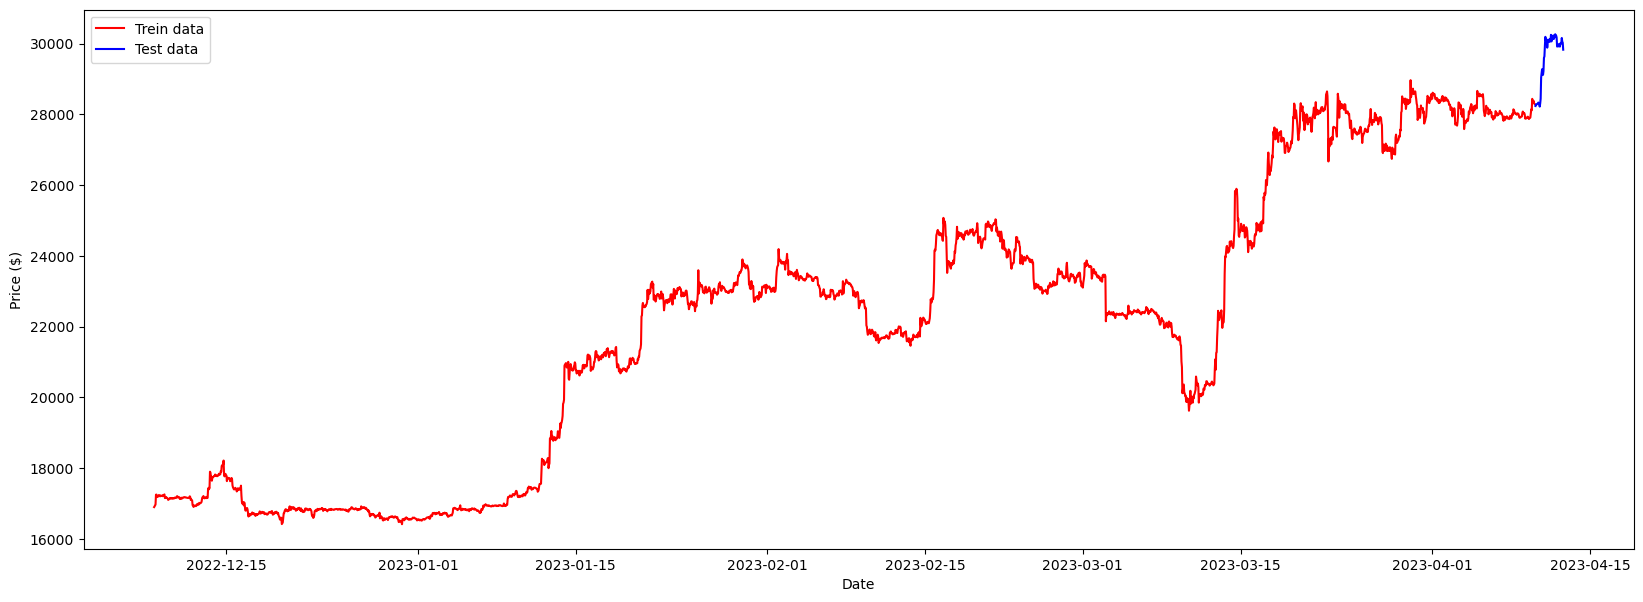

In [50]:
plt.figure(figsize=(20,7))
plt.plot(df['kline_open_time'][:num_shape], df.iloc[:num_shape,4:5].values, color = 'red', label = 'Trein data')
plt.plot(df['kline_open_time'][num_shape:], df.iloc[num_shape:,4:5].values , color = 'blue', label = 'Test data')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [51]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [68]:
X_train = []

#Price on next day
y_train = []

window = 120

for i in tqdm(range(window, num_shape)):
    X_train_ = train_scaled[i-window:i]
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])

X_train = np.stack(X_train)
y_train = np.stack(y_train)

  0%|          | 0/2820 [00:00<?, ?it/s]

In [69]:
df_ = df.iloc[:,4:5].values
inputs = df_[df_.shape[0] - test.shape[0] -window :]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_.shape[0] - num_shape + window 

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [71]:
# Initializing the Recurrent Neural Network
model = Sequential()
#Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
#Units - dimensionality of the output space

model.add(LSTM(units = 120, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 120, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 120, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 120))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 120, 120)          58560     
                                                                 
 dropout_8 (Dropout)         (None, 120, 120)          0         
                                                                 
 lstm_9 (LSTM)               (None, 120, 120)          115680    
                                                                 
 dropout_9 (Dropout)         (None, 120, 120)          0         
                                                                 
 lstm_10 (LSTM)              (None, 120, 120)          115680    
                                                                 
 dropout_10 (Dropout)        (None, 120, 120)          0         
                                                                 
 lstm_11 (LSTM)              (None, 120)              

In [72]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100


2023-04-12 18:28:31.362623: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


89/89 [==============================] - 10s 49ms/step - loss: 0.0111
Epoch 2/100
89/89 [==============================] - 4s 44ms/step - loss: 0.0013
Epoch 3/100
89/89 [==============================] - 4s 44ms/step - loss: 9.9738e-04
Epoch 4/100
89/89 [==============================] - 4s 44ms/step - loss: 8.7155e-04
Epoch 5/100
89/89 [==============================] - 4s 44ms/step - loss: 0.0011
Epoch 6/100
89/89 [==============================] - 4s 44ms/step - loss: 8.9947e-04
Epoch 7/100
89/89 [==============================] - 4s 43ms/step - loss: 7.8355e-04
Epoch 8/100
89/89 [==============================] - 4s 42ms/step - loss: 8.1320e-04
Epoch 9/100
89/89 [==============================] - 4s 42ms/step - loss: 8.5865e-04
Epoch 10/100
89/89 [==============================] - 4s 43ms/step - loss: 7.5210e-04
Epoch 11/100
89/89 [==============================] - 4s 43ms/step - loss: 7.3613e-04
Epoch 12/100
89/89 [==============================] - 4s 43ms/step - loss: 6.8879e-04


In [73]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)



2/2 [==============================] - 1s 56ms/step


In [74]:
df_pred = pd.Series(predict[:,0])
t = pd.Series(test[:,0])
df_pred = pd.concat([df_pred,t], axis = 1)
df_pred = pd.concat([df_pred, pd.Series(df['kline_open_time'][num_shape:].values)], axis = 1)
df_pred.columns = ['pred','real','Date']


In [75]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

MSE: 2560744.2734111054
MAE: 1589.6866888020834
RMSE: 1600.2325685384315


ValueError: x and y must have same first dimension, but have shapes (60,) and (2940, 1)

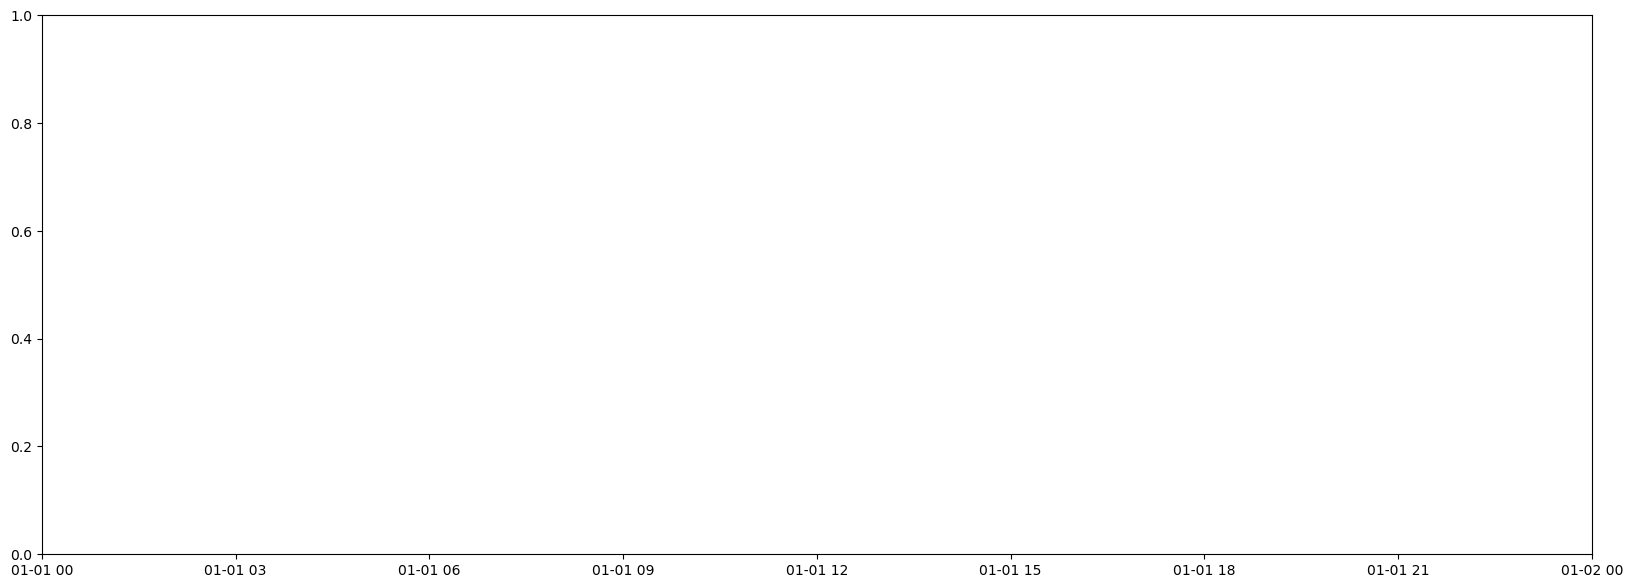

In [79]:
plt.figure(figsize=(20,7))
plt.plot(df['kline_open_time'][num_shape:], df.iloc[:num_shape,4:5].values, color = 'red', label = 'Real Price')
plt.plot(df['kline_open_time'][-predict.shape[0]:], predict, color = 'blue', label = 'Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [28]:
pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = df.iloc[:, 4:5][1:].values

for j in range(10):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]

    inputs_ = df_[df_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = model.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

2/2 [==============================] - 0s 14ms/step


In [29]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

In [30]:
df_date = df[['kline_open_time']]
for h in range(10):
    df_date_add = pd.to_datetime(df_date['kline_open_time'].iloc[-1]) + timedelta(hours=1)
    df_date_add = pd.DataFrame([df_date_add.strftime("%Y-%m-%d %H:%M:%S")], columns=['kline_open_time'])
    df_date = pd.concat([df_date,df_date_add])
df_date = df_date.reset_index(drop=True)



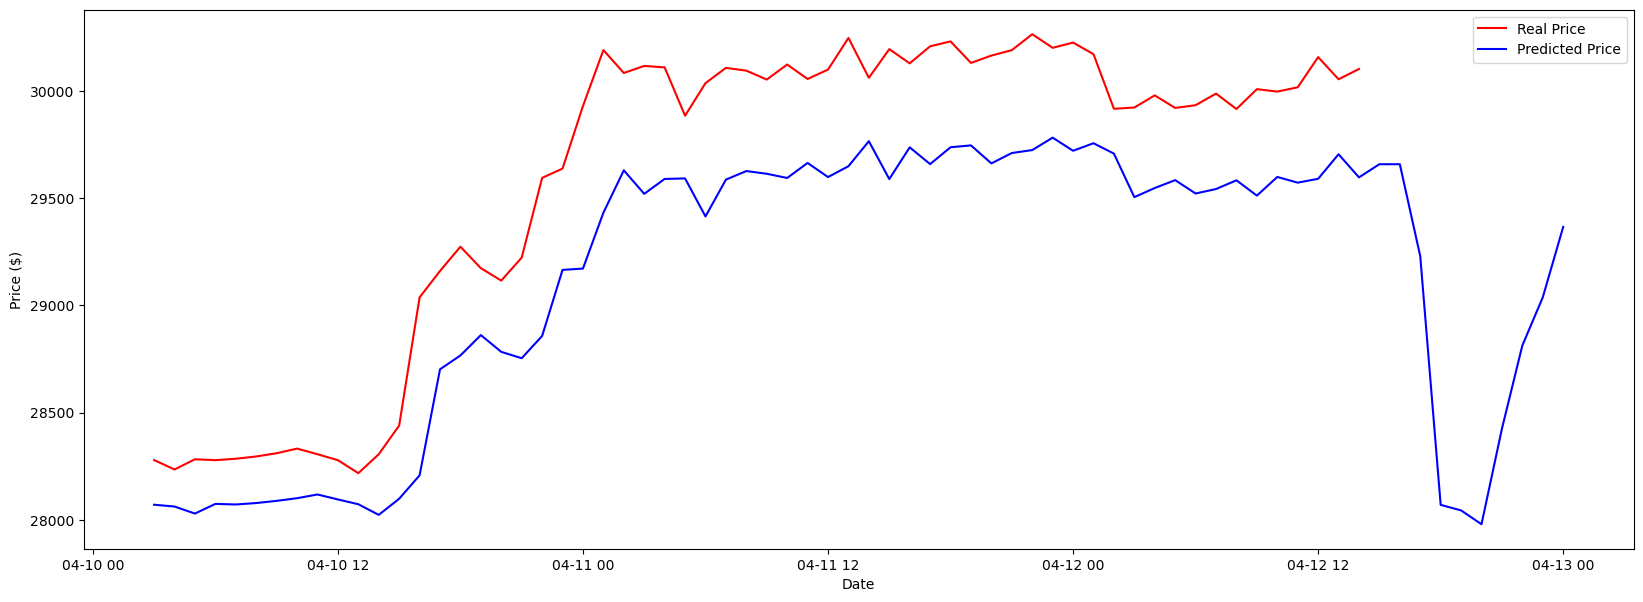

In [32]:
plt.figure(figsize=(20,7))
plt.plot(df['kline_open_time'][num_shape:], df_volume[num_shape:], color = 'red', label = 'Real Price')
plt.plot(df_date['kline_open_time'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [ ]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))
modelGRU.summary()


In [ ]:
modelGRU.compile(optimizer='sgd', loss='mean_squared_error')
modelGRU.fit(X_train, y_train, epochs=10, batch_size=16)


In [ ]:
predict = modelGRU.predict(X_test)
predict = sc.inverse_transform(predict)

In [ ]:
diff = predict - test

print("MSE:", np.mean(diff**2))
print("MAE:", np.mean(abs(diff)))
print("RMSE:", np.sqrt(np.mean(diff**2)))

In [ ]:
pred_ = predict[-1].copy()
prediction_full = []
window = 60
df_copy = df.iloc[:, 4:5][1:].values

for j in range(20):
    df_ = np.vstack((df_copy, pred_))
    train_ = df_[:num_shape]
    test_ = df_[num_shape:]
    
    df_volume_ = np.vstack((train_, test_))

    inputs_ = df_volume_[df_volume_.shape[0] - test_.shape[0] - window:]
    inputs_ = inputs_.reshape(-1,1)
    inputs_ = sc.transform(inputs_)

    X_test_2 = []

    for k in range(window, num_2):
        X_test_3 = np.reshape(inputs_[k-window:k, 0], (window, 1))
        X_test_2.append(X_test_3)

    X_test_ = np.stack(X_test_2)
    predict_ = modelGRU.predict(X_test_)
    pred_ = sc.inverse_transform(predict_)
    prediction_full.append(pred_[-1][0])
    df_copy = df_[j:]

In [ ]:
prediction_full_new = np.vstack((predict, np.array(prediction_full).reshape(-1,1)))

df_date = df[['kline_open_time']]

for h in range(20):
    kk = pd.to_datetime(df_date['kline_open_time'].iloc[-1]) + timedelta(hours=1)
    kk = pd.DataFrame([kk.strftime("%Y-%m-%d %H:%M:%S")], columns=['kline_open_time'])
    df_date = df_date.append(kk)
df_date = df_date.reset_index(drop=True)


In [ ]:
plt.figure(figsize=(20,7))
plt.plot(df['kline_open_time'].values[2000:], df_volume[2000:], color = 'red', label = 'Real Tesla Stock Price')
plt.plot(df_date['kline_open_time'][-prediction_full_new.shape[0]:].values, prediction_full_new, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.xticks(np.arange(100,df_date[2000:].shape[0],300))
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()